In [ ]:
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

import torch
import pickle as pkl
import transformers
import torch.nn as nn
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [ ]:
tqdm.pandas()

device = torch.device('cuda')

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
bert = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/711M [00:00<?, ?B/s]

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/Media_108/ДФ/result_df_num_classes.pkl')

In [ ]:
# Разделение датасета на обучающую, проверочную и тестовую выборки
from sklearn.model_selection import train_test_split
tr_df, val_df     = train_test_split(df,    test_size=0.15,  random_state=30, stratify=df['Класс'])
train_df, test_df = train_test_split(tr_df, test_size=0.15, random_state=30, stratify=tr_df['Класс'])
print(train_df.shape[0], val_df.shape[0], test_df.shape[0])

5002 1039 883


In [ ]:
# Разобьем выборки на текст и таргет

train_text = train_df['Транскрибированный текст'].astype('str')
train_labels = train_df['Класс']
val_text = val_df['Транскрибированный текст'].astype('str')
val_labels = val_df['Класс']
test_text = test_df['Транскрибированный текст'].astype('str')
test_labels = test_df['Класс']

In [ ]:
train_text.values

array(['Добрый вечер, клубный город на реке Примавера, Лилия, слушаю вас. Добрый вечер, клубный город на реке Примавера. Добрый вечер, клубный город на реке Примавера. Добрый вечер. Добрый вечер, клубный город на реке Примавера. Вас не слышно, перезвоните, пожалуйста.',
       'Алло. Алло, здравствуйте. Алло. Да, слушаю. Добрый день, это Лидфлат, клиент зовут Андрей. Еще раз, какой вопрос? Алло. Алло, да. Вы к какому? Вы куда звоните? Хедлайнер. Ага, в отдел веселения? Клиент просит перейти, он хочет обсуждать с вами пару вопросов. Хорошо, переводите. Алло. Да, здравствуйте. Да, добрый день, отдел веселения ЖК Хедлайнер. По поводу парковочных мест вы можете проинформировать, сориентировать. Еще раз, по какому вопросу вы звоните? Мне позвонил менеджер, начал предлагать квартиру, я сказал, что мне интересно было узнать по поводу парковочных мест, он сказал, что ты денис с менеджером. Вы тот менеджер? Да, мы отдел заселения. Ну, я понял, да, я понял. Он мне позвонил, предлагал квартиры, п

### Следующий код выведет график длин предложений. Он поможет определить оптимальную длину последовательности токенов, чтобы избежать разреженных векторов.

<Axes: >

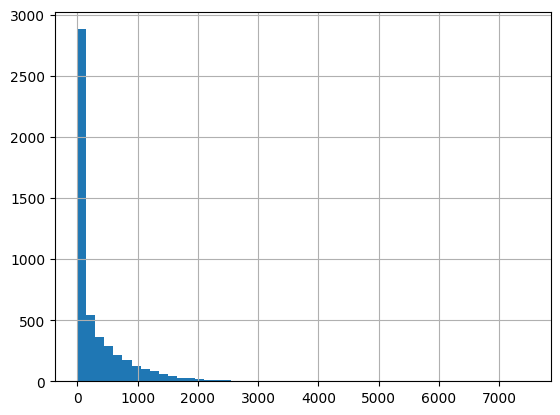

In [ ]:
seq_len = [len(str(i).split()) for i in train_text]
pd.Series(seq_len).hist(bins = 50)

### Токенизируем текста, передадим в тензоры и загрузим в функцию DataLoader, которая будет по частям подавать наши данные для обучения и валидации в модель

In [ ]:
tokens_train = tokenizer.batch_encode_plus(
    train_text.values.tolist(),
    max_length = 512,
    padding = 'max_length',
    truncation = True
)

tokens_val = tokenizer.batch_encode_plus(
    val_text.values.tolist(),
    max_length = 512,
    padding = 'max_length',
    truncation = True
)

tokens_test = tokenizer.batch_encode_plus(
    test_text.values.tolist(),
    max_length = 512,
    padding = 'max_length',
    truncation = True
)

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.values)

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.values)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.values)
batch_size = 8

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

val_data =  TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size)

TypeError: ignored

### Сам BERT обучать не будем. Допишем к его выходу свои слои, которые и будем обучать на классификацию.

In [ ]:
for param in bert.parameters():
    param.requires_grad = False

class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512,2)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask = mask, return_dict = False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [ ]:
#  Объявим модель, загрузим ее в GPU. Импортируем оптимизатор.

model = BERT_Arch(bert)

model = model.to(device)
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr= 1e-3)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Для борьбы с дисбалансом классов используем следующий подход

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

print(class_weights)

[1.15894347 0.87939522]


In [ ]:
weights = torch.tensor(class_weights, dtype = torch.float)
weights = weights.to(device)
cross_entropy = nn.CrossEntropyLoss()
epochs = 5

### Функция для обучения модели

In [ ]:
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []

    for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        batch = [r.to(device) for r in batch]
        sent_id,mask,labels = batch
        model.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)

    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)

    return avg_loss, total_preds

### Функция валидации

In [ ]:
def evaluate():
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []

    for step, batch in tqdm(enumerate(val_dataloader), total = len(val_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

    avg_loss = total_loss / len(val_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)

    return avg_loss, total_preds

### Обучение

In [ ]:
best_valid_loss = float('inf')
best_loss       = float('inf')

train_losses = []
valid_losses = []

for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch + 1, epochs))

    train_loss, _ = train()
    valid_loss, _ = evaluate()

    if valid_loss == best_valid_loss:
        if train_loss < best_loss:
            best_loss = train_loss
            torch.save(model.state_dict(), '/content/drive/MyDrive/Media_108/Bert_веса/BERT_weights.pt')

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/Media_108/Bert_веса/BERT_weights.pt')

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Validation loss: {valid_loss:.3f}')


 Epoch1 / 5


  0%|          | 0/626 [00:00<?, ?it/s]


RuntimeError: ignored

Загрузим лучшие веса для модели

In [ ]:
path = '/content/drive/MyDrive/Media_108/Bert_веса/saved_weights.pt'
model.load_state_dict(torch.load(path))

# Если не хватило видеопамяти. Используем костыль. Разобьем тестовые данные на части и будем отправлять на предсказание по частям

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

list_seq = np.array_split(test_seq, 50)
list_mask = np.array_split(test_mask, 50)


predictions = []
for num, elem in enumerate(list_seq):
    with torch.no_grad():
        preds = model(elem.to(device), list_mask[num].to(device))
        predictions.append(preds.detach().cpu().numpy())

Преобразуем полученные предсказания в один список, нормализуем данные и запишем в новый столбик датафрейма

In [ ]:
flat_preds = [item[1] for sublist in predictions for item in sublist]
flat_preds = (flat_preds - min(flat_preds)) / (max(flat_preds) - min(flat_preds))
test_df['confidence'] = flat_preds

In [ ]:
test_df['Предсказание'] = test_df['confidence'].apply(lambda x: 1 if x > 0.92 else 0)

print(classification_report(test_df['Класс'], test_df['Предсказание']))